In [8]:
import json
import os
import pandas as pd
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")


###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata.csv"


yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 

mdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
mdatadirectory=mdirectory+"/data/marketdata.csv"

marketdata = pd.read_csv(mdatadirectory)
marketdata = marketdata.replace(np.nan, '', regex=True) 


vdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
vdatadirectory=directory+"/data/swaptionvol.csv"

voldata = pd.read_csv(vdatadirectory)
voldata = voldata.replace(np.nan, '', regex=True) 

In [9]:
FRNDefinition={}
FRNDefinition["issueDate"]="2015-07-15"
FRNDefinition["maturityDate"]="2026-06-04"
FRNDefinition["frequency"]="Quarterly"
FRNDefinition["spread"]=0.0
FRNDefinition["calendar"]="Turkey"
FRNDefinition["currency"]="TRY"
FRNDefinition["dateGeneration"]="Backward"
FRNDefinition["dayCounter"]="Actual360"
FRNDefinition["businessDayConvention"]="ModifiedFollowing"
FRNDefinition["maturityDateConvention"]="ModifiedFollowing"
FRNDefinition["redemption"]=100
FRNDefinition["endOfMonth"]=True
FRNDefinition["fixingDate"]=[]
FRNDefinition["fixingRate"]=[]
FRNDefinition

{'issueDate': '2015-07-15',
 'maturityDate': '2026-06-04',
 'frequency': 'Quarterly',
 'spread': 0.0,
 'calendar': 'Turkey',
 'currency': 'TRY',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'redemption': 100,
 'endOfMonth': True,
 'fixingDate': [],
 'fixingRate': []}

In [10]:
instruments={}
depo={}
irs={}

depo["businessDayConvention"]="Following"     # if it is null, default value is used
depo["dayCounter"]="Actual360"                # if it is null, default value is used

irs["businessDayConvention"]="Following"      # if it is null, default value is used 
irs["dayCounter"]="Actual360"                 # if it is null, default value is used 
irs["frequency"]="Semiannual"               

instruments["DEPO"]=depo
instruments["IRS"]=irs

instruments

{'DEPO': {'businessDayConvention': 'Following', 'dayCounter': 'Actual360'},
 'IRS': {'businessDayConvention': 'Following',
  'dayCounter': 'Actual360',
  'frequency': 'Semiannual'}}

In [11]:
# Fix parameters for building yield curve
yieldcurveconfig={
      "name": "TRYZC",
      "settlementDays": 2,
      "intpMethod": "LINEAR",
      "currency": "TRY",
      "calendar": "Turkey",
      "dayCounter": "Actual360",
      "period": "6M",
      "instruments": instruments

    }
yieldcurveconfig

{'name': 'TRYZC',
 'settlementDays': 2,
 'intpMethod': 'LINEAR',
 'currency': 'TRY',
 'calendar': 'Turkey',
 'dayCounter': 'Actual360',
 'period': '6M',
 'instruments': {'DEPO': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360'},
  'IRS': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360',
   'frequency': 'Semiannual'}}}

In [15]:
riskdata = {
  "id": "PORTFOLIO1",
  "name": "PORTFOLIO 1",
  "method": "VaR",
  "forRisk": True,
  "valuationDate": "2021-01-28",
  "valuationCurrency": "TRY",
  "riskMethod": "MONTECARLO",
  "horizon": 252,
  "confidenceInterval": 0.99,
  "returnType": "NONE",
  "trend": False,
  "calendar": "Turkey",
  "timeBucket": ["0D","1D","1W","2W","3W","1M","2M","3M","6M","9M","1Y","2Y","3Y","4Y",
                "5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y","20Y","25Y","30Y","40Y","50Y"],
  "fillNa": "BACKWARD",
  "maxFillNaDays": 5,
  "calibration": True,
  "correlation": False,
  "nPath": 100,
  "nDayVar": 10,
  "alpha": 0.376739,
  "sigma": 0.0209835,
  "tasks": [
            {
      "trade_id": "FLOAT1000",
      "calculation_type": "floating_rate_bond",
      "notional": 1000000,
      "settlementDate": "2021-02-01",
      "buySell": "Buy",
      "discountCurve": "TRYZC",
      "floatingBondDefinition": FRNDefinition
    }
  ],
  "curves": [yieldcurveconfig],
  "yieldData": yielddata.to_dict('r'),
  "marketData":marketdata.to_dict('r'),
  "volatilityData":voldata.to_dict('r'),
}

In [16]:
try:
    res = api.createTask(CalculationType.PORTFOLIO, riskdata, True)
    if(res["result"]):
      result=json.loads(res["result"])
    else:
      print(res["result"])
except RhoovaError as e:
    e.printPretty()

In [17]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', result.get('VaR')])
npvTable.add_row(['VAR/PV (%)', result.get('var/pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+--------------+
| Parameters |        Value |
+------------+--------------+
|         PV | 1000000.0000 |
|        VAR |     109.7869 |
| VAR/PV (%) |       0.0110 |
+------------+--------------+


In [18]:
frn=pd.DataFrame(result.get("portfolioPv"))
frn=frn.iloc[:,1:riskdata.get("nDayVar")]

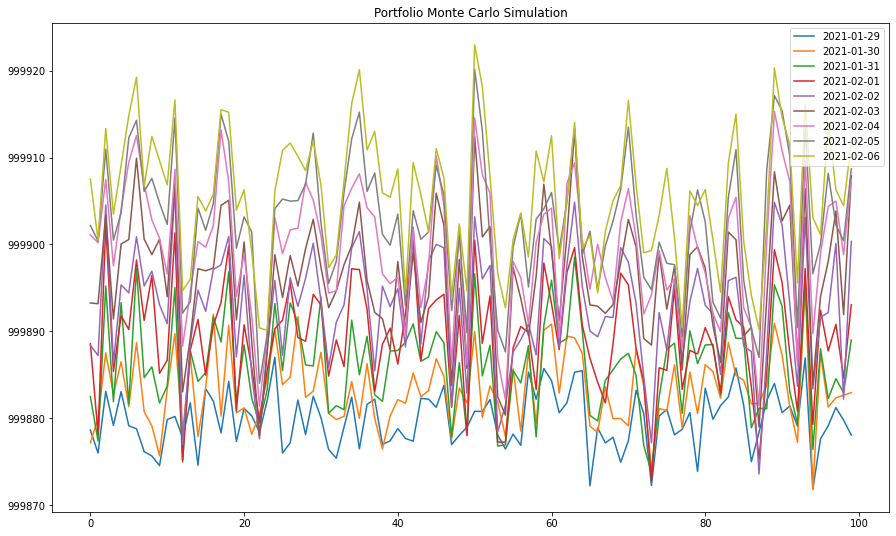

In [19]:
frn.plot(figsize=(15,9)); 
plt.title("Portfolio Monte Carlo Simulation")
plt.legend(loc='best')
plt.show()

In [20]:
frn.quantile(q=0.01, axis=0)-result.get('pv')

2021-01-29   -127.788669
2021-01-30   -125.927966
2021-01-31   -125.065534
2021-02-01   -124.872158
2021-02-02   -123.063809
2021-02-03   -121.032425
2021-02-04   -118.551555
2021-02-05   -113.047106
2021-02-06   -109.786862
Name: 0.01, dtype: float64

In [21]:
pd.DataFrame(result.get("portfolioPv"))

,2021-01-28,2021-01-29,2021-01-30,2021-01-31,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,2021-02-11
0,0,999878.643311,999877.166346,999882.495488,999888.574922,999888.408470,999893.264058,999901.101993,999902.187744,999907.533031,0,0,0,0,0
1,0,999875.985700,999879.985007,999877.360964,999878.184226,999887.218777,999893.176946,999900.200736,999900.398967,999900.492612,0,0,0,0,0
2,0,999883.098944,999887.533217,999895.222258,999902.307821,999904.550381,999903.359637,999907.483202,999910.957396,999913.343806,0,0,0,0,0
3,0,999879.174787,999882.760743,999881.899576,999885.382571,999886.321636,999891.425293,999897.532523,999900.492135,999903.508144,0,0,0,0,0
4,0,999883.063614,999886.498434,999893.296829,999891.783298,999895.353308,999900.055958,999904.027440,999903.643870,999909.116828,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,999877.625004,999887.495132,999887.991731,999892.422660,999891.609328,999894.030376,999899.014052,999900.051661,999901.141672,0,0,0,0,0
96,0,999879.134799,999881.282647,999882.253553,999887.738364,999892.174509,999898.060147,999904.382206,999908.202852,999914.076791,0,0,0,0,0
97,0,999881.222472,999882.349762,999884.549777,999890.803057,999900.123815,999903.862268,999904.999365,999902.240606,999906.308478,0,0,0,0,0
98,0,999879.779587,999882.638396,999882.925720,999884.625002,999882.202794,999891.927331,999898.827232,999900.426000,999904.452387,0,0,0,0,0
